# Introduction

For this project, we designed a KNN-classification model that predicts the presence of forest fires in Bejaia, Algeria under specific weather conditions. The Bejaia region has a coastal Mediterranean climate with warm, dry summers which are often optimal conditions for such forest fires. The UCI Machine Learning Database contains a dataset with observations of forest fires in the Bejaia region from June to September 2012, which we used for classification. This dataset also contains observations of forest fires in the Sidi Bel Abbes region of Algeria during the same time frame, which we did not use in designing our model.

Within the Algerian forest fires dataset, each observation is one calendar day and contains a label of “fire” or “not fire” along with a record of multiple other weather factors. The factors we chose as predictors are the maximum daily temperature in Celsius (°C), the maximum daily wind speed in km/h, and the day’s Fire Weather Index (FWI) value. The Fire Weather Index is a meteorologically based measuring unit of fire danger that encompasses multiple moisture and drought codes, an initial spread index, and a buildup index. FWI values fall on an open-ended scale, with ranges in the dataset from 0 to 31.1.

The predictors we chose besides FWI are the weather factors not included in the FWI value calculation that we felt would correlate with whether or not a fire began. This includes temperature and wind speed. Temperature affects fire prevalence by drying out forests and providing tinder, which aids in starting a fire. Wind speed affects whether or not a stray spark can travel enough to find tinder, how much oxygen it's supplied, and how much a fire spreads once it has begun. All of the other variables in the dataset, including relative humidity (RH), the volume of rain, Fine Fuel Moisture Code (FFMC), Duff Moisture Code (DMC), Drought Code (DC), Initial Spread Index (ISI), and Buildup Index (BUI) are factored into the calculation of the Fire Weather Index values and are therefore not directly used as predictors in the KNN-classification, though they indirectly affect the classification model. We will be answering the question: Can the wind speed, temperature, and FWI of any given summer day predict whether the forest region of Bejaia, Algeria is on fire?

# Methods and Results

### Reading and Loading Data

We began by loading the necessary packages: `repr`, `tidyverse`, and `tidymodels`.

In [26]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

After loading the packages, we read the data and cleaned as necessary. We removed the date columns, as they are not relevant to our classification, and mutated the `Classes` column to be a factor so it can be used as the classifier. A parsing failure occurred because of the original dataset’s formatting, which puts region titles in rows 123 and 168, throwing off the rest of the data. As we only used rows 1-122 (the Bejaia region data), this failure can be ignored.

In [27]:
fire_data_read <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                      skip = 1)

fire_data_full <- slice(fire_data_read, 1:122) %>%
    mutate(Classes = as_factor(Classes)) %>% 
    select(-day, -month, -year) %>% 
    mutate(across(Temperature:FWI, as.double))
fire_data_full

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
32,47,14,0.7,77.5,7.1,8.8,1.8,6.8,0.9,not fire
26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,not fire
25,78,14,1.4,45.0,1.9,7.5,0.2,2.4,0.1,not fire


*Table 1: Loaded dataset with irrelevant columns*

Next, we selected the variables we used as predictors: temperature (`Temperature`), wind speed (`Ws`), and Fire Weather Index (`FWI`), along with the `Classes` variable to create our cleaned dataset.

In [28]:
fire_data <- fire_data_full %>% 
    select(Temperature, Ws, FWI, Classes)
fire_data

Temperature,Ws,FWI,Classes
<dbl>,<dbl>,<dbl>,<fct>
29,18,0.5,not fire
29,13,0.4,not fire
26,22,0.1,not fire
⋮,⋮,⋮,⋮
32,14,0.9,not fire
26,16,0.1,not fire
25,14,0.1,not fire


*Table 2: Cleaned dataset, ready to be used in classification*

### Preliminary Data Analysis

To begin, we set the seed to be 1 and split the data into training and testing sets with a 70/30 split. To find the accuracy of the model if only the majority class was guessed, we counted the proportion of “fire” to “not fire” observations in the training set and testing set. The accuracy of the majority class was 52% for both sets, which is very low, therefore we expected our model to be significantly better than that.

In [29]:
set.seed(1)


fire_split <- initial_split(fire_data, prop = 0.7, strata = Classes)
fire_training <- training(fire_split)
fire_testing <- testing(fire_split)


class_counts_training <- fire_training %>%
    group_by(Classes) %>%
    summarize(count = n()) %>% 
    mutate(fraction = count/nrow(fire_training))
class_counts_training

class_counts_testing <- fire_testing %>%
    group_by(Classes) %>%
    summarize(count = n()) %>% 
    mutate(fraction = count/nrow(fire_testing))
class_counts_testing

`summarise()` ungrouping output (override with `.groups` argument)



Classes,count,fraction
<fct>,<int>,<dbl>
not fire,45,0.5172414
fire,42,0.4827586


`summarise()` ungrouping output (override with `.groups` argument)



Classes,count,fraction
<fct>,<int>,<dbl>
not fire,18,0.5142857
fire,17,0.4857143


*Table 3: Fraction of each class in the training dataset (top) and the testing dataset (bottom)*

Next, we calculated the mean value of each predictor, to see what the average day during our time period would look like.

In [30]:
predictor_means <- fire_training %>%
    select(Temperature:FWI) %>%
    map_df(mean) %>%
    pivot_longer(cols = Temperature:FWI,
                names_to = "Predictor",
                values_to = "Mean")
predictor_means

Predictor,Mean
<chr>,<dbl>
Temperature,31.149425
Ws,15.942529
FWI,5.733333


*Table 4: Mean value of each predictor*

To better understand the training data, we plotted the distribution of each predictor, as well as scatter plots of each possible combination of the predictors.
<br>The following visualization shows the prevalence of each temperature observation and whether the observation is labelled "fire" or "not fire". Under 30° C, very few fires are observed, and above 35° C, nearly every observation is of fire.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


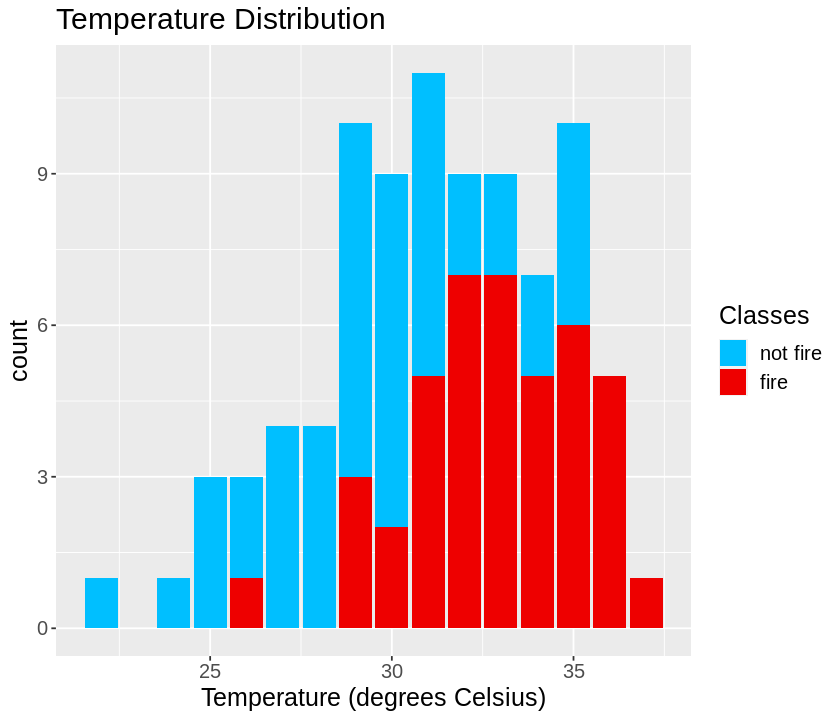

In [31]:
options(repr.plot.width = 7, repr.plot.height = 6)

temp_dstn_plot <- fire_training %>%
    ggplot(aes(x = Temperature, fill = Classes)) + 
    geom_histogram(stat = "count", binwidth = 1) +
    labs(x = "Temperature (degrees Celsius)") + 
    ggtitle("Temperature Distribution") +
    scale_fill_manual(values = c("deepskyblue1", "red2")) +
    theme(text = element_text(size = 15))
temp_dstn_plot

*Figure 1: Distribution of temperature values coloured by class*

This visualization is of the distribution of windspeed observations and whether they are labelled "fire" or "not fire". The windspeed does not seem to correlate strongly to either class, though very few observations of fire are seen above 19 km/h.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


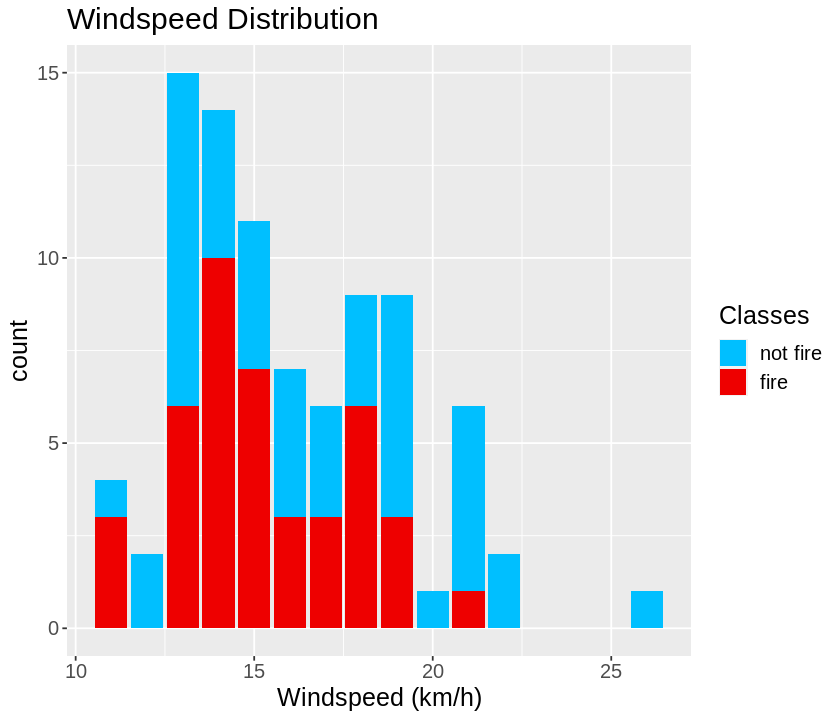

In [32]:
ws_dstn_plot <- fire_training %>%
    ggplot(aes(x = Ws, fill = Classes)) + 
    geom_histogram(stat = "count") +
    labs(x = "Windspeed (km/h)") + 
    ggtitle("Windspeed Distribution") +
    scale_fill_manual(values = c("deepskyblue1", "red2")) +
    theme(text = element_text(size = 15))
ws_dstn_plot

*Figure 2: Distribution of windspeed values coloured by class*

This visualization shows the distribution of Fire Weather Index observations and their corresponding label of "fire" or "not fire". As seen here, FWI values of over 4 are highly correlated with an observation of fire. There are no days with an FWI value of 6 or above where fire is *not* observed.

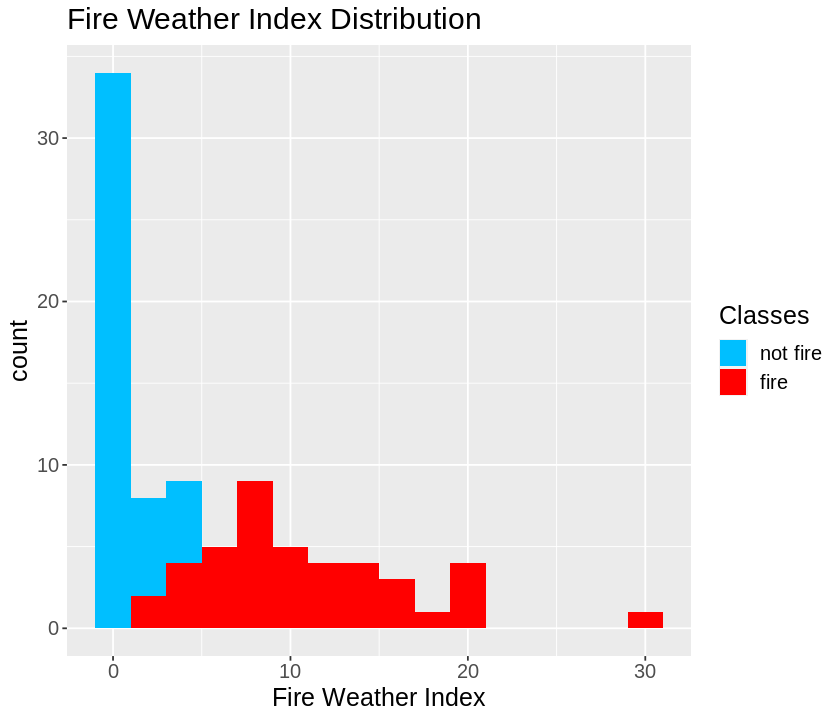

In [33]:
options(repr.plot.height = 6, repr.plot.width = 7)

FWI_dstn_plot <- fire_training %>%
    ggplot(aes(x = FWI, fill = Classes)) + 
    geom_histogram(binwidth = 2) +
    labs(x = "Fire Weather Index") + 
    ggtitle("Fire Weather Index Distribution") +
    theme(text = element_text(size = 15)) +
    scale_fill_manual(values = c("deepskyblue1", "red1"))

FWI_dstn_plot

*Figure 3: Distribution of FWI values coloured by class*

This visualization plots windspeed versus temperature and labels each observation according to its class as "fire" or "not fire". Windspeeds of 15–20 km/hr together with temperatures above 33° C are most likely to be on fire.

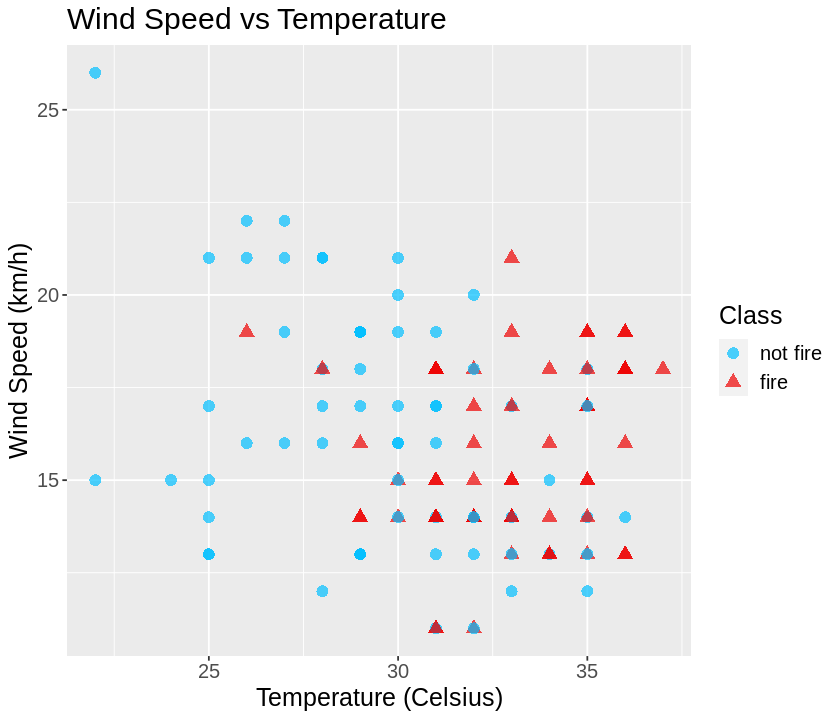

In [34]:
temp_ws_plot <- ggplot(fire_data, aes(x = Temperature, y = Ws)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "Wind Speed (km/h)", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2")) +
    ggtitle("Wind Speed vs Temperature")

temp_ws_plot

*Figure 4: Plot of windspeed vs temperature values*

This visualization plots Fire Weather Index versus temperature. FWI values of 5 and above together with temperatures of above 30° C are most likely to be on fire, with strong correlation between the variables and little overlap between the "fire" and "not fire" groups.

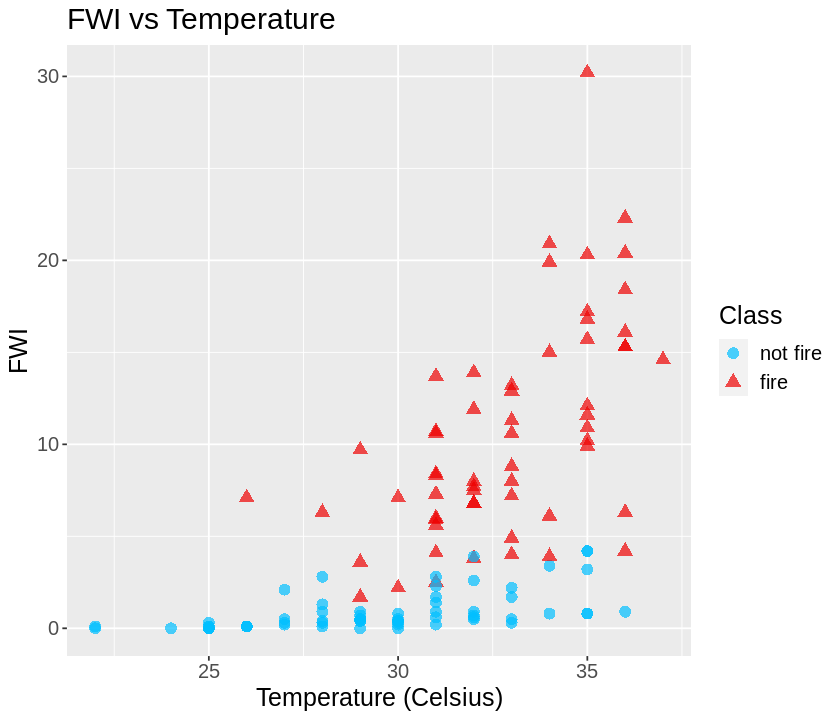

In [35]:
temp_FWI_plot <- ggplot(fire_data, aes(x = Temperature, y = FWI)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2")) +
    ggtitle("FWI vs Temperature")
    
temp_FWI_plot

*Figure 5: Plot of FWI vs temperature values*

This visualization plots Fire Weather Index versus wind speed. There is not strong correlation between the variables, but there is also not much overlap between the "fire" and "not fire" classes. Fire is most likely to occur when FWI values are above 5 and wind speeds are below 18 km/h. 

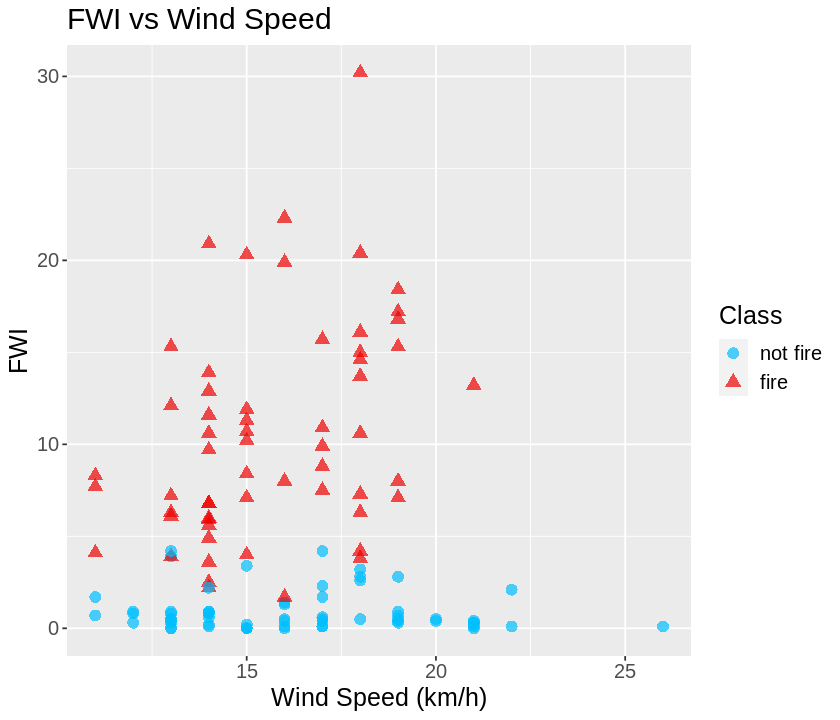

In [36]:
WS_FWI_plot <- ggplot(fire_data, aes(x = Ws, y = FWI)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Wind Speed (km/h)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2")) +
    ggtitle("FWI vs Wind Speed")
    
WS_FWI_plot

*Figure 6: Plot of FWI vs windspeed values*

### Classification Methods

To begin the classification, we created a model specification that calculates Euclidean distance and uses KNN classification, with neighbours set to tune() so we could do cross-evaluation.

In [37]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

We then set the seed again to make sure random splits would be reproducible and split the training data into five folds to use in cross-evaluation.

In [38]:
set.seed(1)

fire_crossval <- vfold_cv(fire_training, v = 5, strata = Classes)

We then created a recipe that specifies `Classes` as the label variable and `Temperature`, `FWI`, and `Ws` (wind speed) as the predictor variables, and scales and centers all of the data.

In [39]:
fire_recipe <- recipe(Classes ~ FWI + Temperature + Ws, data = fire_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

Next, we made our first workflow, which used `tune_grid()` to perform a cross-evaluation.

In [ ]:
fire_resample <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = fire_crossval)

The estimated accuracy of each number of neighbours was calculated using `metrics()`, which told us that 3 neighbours were the most accurate, followed closely by 4 neighbours, though even the lowest accuracy is still quite high at 87%.

In [ ]:
fire_crossval_metrics <- collect_metrics(fire_resample) %>% 
    filter(.metric == "accuracy") %>% 
    arrange(desc(mean))
fire_crossval_metrics
k_val <- pull(fire_crossval_metrics[1,1])

*Table 5: Estimated accuracy of each k-value*

We created a new model specification and a new workflow, this time using the k-value with the highest accuracy, and `fit()` instead of `tune_grid()`. The old recipe was reused, as nothing had changed.

In [ ]:
fire_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = k_val) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

In [ ]:
fire_fit <- workflow() %>% 
    add_recipe(fire_recipe) %>% 
    add_model(fire_spec) %>% 
    fit(data = fire_training)

To finish the classification, we used the classification model created to predict the `Classes` variable of the testing data and bound the predictions to the testing dataset using `bind_cols()`.

In [ ]:
fire_predictions <- predict(fire_fit, fire_testing) %>% 
    bind_cols(fire_testing)

### Classification Results

In [ ]:
fire_metrics <- fire_predictions %>% 
    metrics(truth = Classes, estimate = .pred_class) %>% 
    filter(.metric == "accuracy")
fire_metrics

*Table 6: Accuracy of final classification model*

In [ ]:
fire_conf_mat <- fire_predictions %>% 
    conf_mat(truth = Classes, estimate = .pred_class)
fire_conf_mat

*Table 7: Confusion matrix for the final classification model*

Should note: In this case, a false negative is worse than a false positive, so it's a little problematic that the model erred on the side of "not fire" rather than on the side of "fire". However, with an accuracy of 90%, the model is by far accurate enough to be useful on a day-to-day basis.

In [ ]:
fire_wrong_prediction_labeled <- fire_predictions %>% 
    filter(.pred_class != Classes)
fire_prediction_intermediate <- fire_predictions %>% 
    filter(.pred_class == Classes)
df0 <- subset(fire_wrong_prediction_labeled, select = -c(Classes))

df = subset(fire_wrong_prediction_labeled, select = -c(.pred_class,Temperature, Ws, FWI) )
df_new = cbind(df0, c("fire predicted as not fire")) %>% 
    rename()
colnames(df_new) <- c(".pred_class", "Temperature", "Ws", "FWI", "Classes")
df_new <- df_new %>% 
    mutate(Classes = as.factor(Classes))
fire_new <- rbind(fire_prediction_intermediate, df_new)

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 8)

t_vs_ws_results <- fire_new %>% 
    ggplot(aes(x = Temperature, y = Ws, color = Classes, shape = Classes)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "Windspeed (km/h)", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2", "black")) +
    ggtitle("Windspeed vs Temperature with \n Incorrect Predictions")
    
t_vs_ws_results 

*Figure 7: Plot of windspeed vs temperature with 
incorrect predictions plotted as black squares*

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 8)

t_vs_fwi_results <- fire_new %>% 
    ggplot(aes(x = Temperature, y = FWI, color = Classes, shape = Classes)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2", "black")) +
    ggtitle("FWI vs Temperature with \n Incorrect Predictions")
    
t_vs_fwi_results 

*Figure 8: Plot of FWI vs temperature with incorrect predictions plotted as black squares*

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 8)

t_vs_ws_results <- fire_new %>% 
    ggplot(aes(x = Ws, y = FWI, color = Classes, shape = Classes)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Windspeed (km/h)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2", "black")) +
    ggtitle("FWI vs Windspeed with \n Incorrect Predictions")
    
t_vs_ws_results

*Figure 9: Plot of FWI vs windspeed with incorrect predictions plotted as black squares*

# Discussion

The final KNN classification model with k = 3 neighbours was able to predict the fire/not-fire classes of the testing data with a 91% accuracy. Considering that the majority classifier would have a baseline accuracy of 51%, a final accuracy of 91% is outstanding. As this model is potentially able to warn residents of the Bejaia area of fire, an accuracy of even 75% percent would have been useful. An accuracy of 91% means that the model is extremely helpful and could potentially prevent many catastrophes caused by fire if meteorologists work in tandem with local authorities. 

In the final classification, there were only three incorrect false-negative predictions (fire predicted as not fire). This is important to note as it has implications for practical uses of the model. The false-negative predictions in themselves are not ideal as the prediction would cause more damage than a false-positive; a fire would catch people off guard and unprepared. However, the misclassification of only three data points out of thirty-five means the model is still quite accurate. Potential users of the model should simply be aware that while they should approach “not fire” predictions with a little bit of caution, they can rely on the fact that if the model predicts “fire” there will almost certainly be a fire. 

From figures 7, 8, and 9, it can be seen that the incorrect predictions are largely caused by values on the FWI axis. This is because, in figures 8 and 9, the incorrect prediction points all lie at around 3-4 FWI across a horizontal line, suggesting that in that FWI range, the predictions are more likely to be incorrect. Another supporting factor for FWI being the main contributor to these incorrect predictions is in figure 7, the incorrect prediction points seem to have no relation to either the windspeed axis or the temperature axis. This trend in FWI being the major predictor is further supported by figures 5 and 6, showing a clear separation of the fire and not-fire classes along a line of specific FWI values on the plot. 

This finding is to be expected from our understanding of the FWI index. Widely used since 1976, the FWI index is considered to be the main predictor of whether there will or will not be a fire, as it integrates many different weather observations into one number that gives a good idea of overall fire weather. The predictor accuracy of the FWI value is reflected in the high accuracy of the model, and the large effect the FWI value has on the classification of an observation. 

The findings from this classification model could have many potential impacts. The model provides an accurate method to predict fire that meteorologists in regions prone to forest fires could use, given that they have the needed weather factors. Not only that, but the visualization of the model also shows which variable has the greatest influence on the prediction model itself, which could be very useful for meteorologists to know and take into consideration when developing future models. 

This brings to mind future areas of research that could stem from this classification model. We only considered FWI, temperature, and wind speed in our model, but there may be other weather-related variables that have a significant impact on the prediction of weather conditions as fire or not fire. This could be explored by looking at the distribution of classes across each variable. A stark division between fire and not fire, as seen in FWI values, would indicate a good predictor. Furthermore, future models could look into whether FWI alone is a good enough predictor, as using only a single value to decide on fire danger makes it easier for meteorologists to decide whether or not to alert people in the area. This classification model is only the beginning, and improvements to the model could end up saving the lives and homes of many people living in areas regularly afflicted by forest fires.

# References

Algerian Forest Fires Dataset  . (2019). UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++.

Chelli, Stefano, et al. “Adaptation of the Canadian Fire Weather Index to Mediterranean Forests.” *Natural Hazards*, vol. 75, no. 2, 11 Jan. 2014, pp. 1795–1810., https://doi.org/10.1007/s11069-014-1397-8.

Di Giuseppe, Francesca, et al. “Using the Fire Weather Index (FWI) to Improve the Estimation of Fire Emissions from Fire Radiative Power (FRP) Observations.” *Atmospheric Chemistry and Physics*, vol. 18, no. 8, 2018, pp. 5359–5370., https://doi.org/10.5194/acp-18-5359-2018.

“Fire Weather Index (FWI) System.” *NWCG*, 8 July 2021, https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system.

Turner, J. A., and B. D. Lawson. *Weather in the Canadian Forest Fire Danger Rating System: A User Guide to National Standards and Practices.* Canadian Forestry Service, 1978.

“Understanding Fire Weather.” *Understanding Fire Weather | AAF - Agriculture and Forestry*, 24 July 2020, https://wildfire.alberta.ca/wildfire-status/fire-weather/understanding-fire-weather.aspx.